<div align="center"> 

---

# **Partial least squares**

</div>

----

<div align="center"> 

![ModelDesign_IA2BC.png]()

</div>

---
# <u> **Description:**</u>

Alcohol consumption of the rats of the six batches over the four months of the protocol.

---

## **Workflow**

1. Downloading files from drive
2. Data preparation
3. Analyses
4. Exploratory data
5. Visualization

---

**Variables to consider:** 
  - Session
  - Sex  
  
**Metrics**
  - Consumption pattern
  - Alcohol deprivation effect (ADE)
  
**Analysis:**
  - Latent class analysis 

---

### **General settings options**

In [1]:
addTaskCallback(function(...) {set.seed(42);TRUE})
options(warn=-1) # to turn off warnings
#options(warn=0) # to turn on warnings
options(repr.plot.width=12, repr.plot.height=8) # to resize plots

1 
1

## **1. Preparation**

### **1.1 Load  R packages and dependencies.** 

  The following packages are needed for the to move on, firstly it is needed to download pacman library

 ---

In [2]:
# Make sure to install pacman before we begin
  if (!require("pacman")) {
  install.packages("pacman")
  }

# Load required packages  
  pacman::p_load(tidyverse,devtools,ggpubr,ggthemes,SmartEDA,lme4,performance,rstatix,data.table,png,grid,gridExtra,
    hablar,cowplot,lcmm,plotrix,report,broom,easystats,emmeans,sjPlot,boot,ggdist,gghalves,patchwork,
    corrplot,magrittr,PTCA4CATA,plotly,colorspace,tableone,reshape2,ggridges,rmatio,tidyplots,FactoMineR,factoextra)

Loading required package: pacman



In [3]:
## Settings color and theme

pal_group <- c("#757575","#C96505","#00A087","#09467C")
pal_sex <- c(alpha("#8E5A9C",1),alpha("#2879BC",1))
theme_settings <- theme(text = element_text(size=20,family = "Times New Roman"),axis.text.x = element_text(size=18),legend.title=element_blank())

In [4]:
setwd("/mnt/g/Other computers/My Laptop/PhD/Psilantro/Sudmex_alcohol_stress/")

## **2. Data preparation**

Reading files and set it all up for Alcohol group

In [5]:
load("Data/Alcohol_consumption.RData")
load("Data/Behavior_metricsEPM.Rdata")
load("Data/Behavior_metricsNOR.Rdata")
load("Data/Behavior_metricsCPP.Rdata")
load("Data/sMRI.RData")
load("Data/fMRI.RData")

#### Read some files

In [6]:
# data_4pls <- read_csv("Data/Behavior/PLS_preparation/Behavior_metrics4pls.csv") %>% 
#   select(-Batch) %>% 
#   #replace -0 with - in RID column
#   mutate(RID = str_replace_all(RID,"-0","-")) %>% select(-c(EPM_Stage,Group,sex_1m,Sex))

# files_names <- list.files("Data/MRI/DBM/jacobians/") %>% 
#   #keep only those who has "T3" in the name
#   keep(~ grepl("T3", .)) %>%
#   keep(~ grepl("nii.gz", .)) 

# files_names %>%
#   str_split(pattern="_") %>% map(~ .x[[1]]) %>% reduce(rbind) %>% as_tibble() %>% 
#   add_column(relative_jacobian = files_names) %>% 
#   set_colnames(c("RID","relative_jacobian")) %>% right_join(data_4pls,by = "RID") %>% 
#   mutate(relative_jacobian = paste0("/data/chamal/projects/jalilr/pls/mice_data/relative_jacobians/nii/t3_pls/",relative_jacobian)) %>% 
# #     # mutate(Ctrl1 = case_when(Group == "Ctrl" ~ 1, TRUE ~ 0),
# #     #     Alc1 = case_when(Group == "Alc" ~ 1, TRUE ~ 0),
# #     #     Str1 = case_when(Group == "Str" ~ 1, TRUE ~ 0),
# #     #     AlcStr1 = case_when(Group == "Alc+Str" ~ 1, TRUE ~ 0), .before = 3) %>% 
# #   select(-Sex) %>% 
#   write_csv("Data/Behavior/PLS_preparation/DLC_tracked_4pls_path.csv")

In [7]:
allEPM_metrics <- EPM_AI %>% dplyr::select(RID,Group,Batch,Sex,Stage,PI,PI_entries,Anxiety_index) %>% 
    left_join(Report_DLC %>% dplyr::select(-file)) %>% filter(Stage == "T2") %>%
    mutate(Group = fct_relevel(Group, "Ctrl", "Alc", "Str", "Alc+Str"))

Models_allEPM_metrics <- allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% 
    colnames() %>% map(~ lm(eval(paste0(.x," ~ Group*Sex + Batch")), data = allEPM_metrics)) %>% 
    set_names(allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames())

suppressMessages(invisible(capture.output(
Contrast_allEPM_metrics <- Models_allEPM_metrics %>%
    map(~ contrast(emmeans(.x,~ Group|Sex), method = "pairwise", adjust = "none")) %>% 
    set_names(allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames())
    )))

suppressMessages(invisible(capture.output(
Eff_size_allEPM_metrics <- allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames() %>%
    map(~ eff_size(Contrast_allEPM_metrics[[.x]], sigma = sigma(Models_allEPM_metrics[[.x]]),
                    edf = df.residual(Models_allEPM_metrics[[.x]]) ) ) %>% 
    set_names(allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames()) 
    )))

Joining with `by = join_by(RID, Group, Batch, Sex, Stage)`


In [8]:
allNOR_metrics <- NOR_II %>% dplyr::select(RID,Group,Batch,Sex,PI,PI_entries,Interaction_index) %>% 
    left_join(NOR_Report_DLC %>% dplyr::select(-file)) %>% mutate(Group = fct_relevel(Group, "Ctrl", "Alc", "Str", "Alc+Str"))

Models_allNOR_metrics <- allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% 
    colnames() %>% map(~ lm(eval(paste0(.x," ~ Group*Sex + Batch")), data = allNOR_metrics)) %>% 
    set_names(allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames())

suppressMessages(invisible(capture.output(
Contrast_allNOR_metrics <- Models_allNOR_metrics %>%
    map(~ contrast(emmeans(.x,~ Group|Sex), method = "pairwise", adjust = "none")) %>% 
    set_names(allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames())
    )))

suppressMessages(invisible(capture.output(
Eff_size_allNOR_metrics <- allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames() %>%
    map(~ eff_size(Contrast_allNOR_metrics[[.x]], sigma = sigma(Models_allNOR_metrics[[.x]]),
                    edf = df.residual(Models_allNOR_metrics[[.x]]) ) ) %>% 
    set_names(allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames()) 
    )))

Joining with `by = join_by(RID, Group, Batch, Sex)`


In [9]:
EPM_significant_metrics <- Contrast_allEPM_metrics %>% names() %>% map(~ Contrast_allEPM_metrics[[.x]] %>% as.data.frame() %>% 
        add_column(Metric = paste0(rep(.x,12)), .before = 1) ) %>% 
    map_df(~ .x %>% filter(p.value < 0.05))

NOR_significant_metrics <- Contrast_allNOR_metrics %>% names() %>% map(~ Contrast_allNOR_metrics[[.x]] %>% as.data.frame() %>% 
        add_column(Metric = paste0(rep(.x,12)), .before = 1) ) %>% 
    map_df(~ .x %>% filter(p.value < 0.05))


In [10]:
data_4pls <- allNOR_metrics %>% 
    #dplyr::select(RID, Group, Batch, Sex, NOR_names_4pls %>% names()) %>%
    rename_with(~ paste0("NOR_", .), -c(RID, Group, Batch, Sex)) %>% 
    left_join(
    allEPM_metrics %>% #dplyr::select(RID, Group, Batch, Sex, EPM_names_4pls %>% names()) %>% 
    rename_with(~ paste0("EPM_", .), -c(RID, Group, Batch, Sex)) ) %>% 
    mutate(sex_1m = case_when(Sex == "male" ~ 1, Sex == "female" ~ 0), .before = Sex) %>% 
    mutate(across(6:25, ~ ifelse(is.nan(.), 0, .))) %>%
  select(-Batch) %>% 
  #replace -0 with - in RID column
  mutate(RID = str_replace_all(RID,"-0","-")) %>% select(-c(EPM_Stage,Group,sex_1m,Sex))

files_names <- list.files("Data/MRI/DBM/jacobians/") %>% 
  #keep only those who has "T3" in the name
  keep(~ grepl("T3", .)) %>%
  keep(~ grepl("nii.gz", .)) 

Joining with `by = join_by(RID, Group, Batch, Sex)`


In [11]:
Behavior_metrics <- files_names %>%
  str_split(pattern="_") %>% map(~ .x[[1]]) %>% reduce(rbind) %>% as_tibble() %>% 
  add_column(relative_jacobian = files_names) %>% 
  set_colnames(c("RID","relative_jacobian")) %>% left_join(data_4pls,by = "RID") %>% 
  mutate(relative_jacobian = paste0("/data/chamal/projects/jalilr/pls/mice_data/relative_jacobians/nii/t3_pls/",relative_jacobian))   %>% 
    left_join(Volumes_jacobians %>% select(RID,Group,Sex) %>% unique(), by = c("RID")) %>% 
    mutate(Group = factor(Group, levels = c("Ctrl","Alc","Str","Alc+Str")))

In [12]:
signif_Metric_Measure <- tibble(Metric = c(EPM_significant_metrics$Metric %>% unique(),NOR_significant_metrics$Metric %>% unique())) %>%
    mutate(Metric = str_replace_all(Metric,"body","EPM_body"),
            Metric = str_replace_all(Metric,"nose", "NOR_nose"),
            Metric = str_replace_all(Metric,"PI", "NOR_PI"),
            Metric = str_replace_all(Metric,"PI_entries", "NOR_PI_entries"))

In [41]:
Behavior_allmetrics4pls <- Behavior_metrics %>% select(c("RID","relative_jacobian","Group","Sex",
    Behavior_metrics %>% colnames() %>% 
    keep(~ . %in% (signif_Metric_Measure$Metric))))  %>%
    left_join(General_intake %>% filter(Session == 20, Phase == "Model", Bottle == "EtOH") %>% 
    select(RID,Sex,Group,Weight_kg, main_intake) %>% 
    mutate(main_intake = case_when(main_intake <=12 ~ main_intake ))   %>%
    mutate(RID = str_replace_all(RID,"-0","-"), 
           main_intake = case_when(Group == "Ctrl" ~ 0,
                                   Group == "Alc" ~ main_intake,
                                   Group == "Str" ~ 0,
                                   Group == "Alc+Str" ~ main_intake),
            Weight_kg = case_when(RID == "sub-124" ~ 0.404, 
                RID == "sub-128" ~ 0.434,
                RID == "sub-134" ~ 0.430,
                RID == "sub-135" ~ 0.495,
                TRUE ~ Weight_kg) )
     ) %>% unique() %>%
    mutate(main_intake = case_when(is.na(main_intake) ~ 0, TRUE ~ main_intake)) %>%
    select(-c(Bottle,relative_jacobian)) %>% 
    drop_na() 
Behavior_allmetrics4pls %>%
    select(-c(RID,Group,Sex)) %>% write_csv("Data/Behavior/PLS_preparation/Behavior_metrics4pls.csv")

Adding missing grouping variables: `Bottle`
Joining with `by = join_by(RID, Group, Sex)`


### Borrar

In [14]:
Metric_Measure <- readxl::read_xlsx("Data/Behavior/PLS_preparation/Metrics_measures.xlsx") %>% filter(Measure != "remove") %>%
    mutate(Metric = str_replace_all(Metric,"body","EPM_body"),
            Metric = str_replace_all(Metric,"nose", "NOR_nose"))

In [15]:
Behavior_metrics_4pca <- Behavior_metrics %>% select(c("RID","relative_jacobian","Group","Sex",
    Behavior_metrics %>% colnames() %>% 
    keep(~ . %in% (Metric_Measure$Metric)))) %>%
    pivot_longer(cols = -c(RID,relative_jacobian,Group,Sex), names_to = "Metric",values_to = "value") %>%
    left_join(Metric_Measure, by = "Metric") %>% 
    pivot_wider(names_from = "Metric",values_from = "value")

In [16]:
# For all metrics (python)
Behavior_allmetrics4pls <- Behavior_metrics %>% select(c("RID","relative_jacobian","Group","Sex",
    Behavior_metrics %>% colnames() %>% 
    keep(~ . %in% (Metric_Measure$Metric))))  %>%
    left_join(General_intake %>% filter(Session == 20, Phase == "Model", Bottle == "EtOH") %>% 
    select(RID,Sex,Group,Weight_kg, main_intake) %>% 
    mutate(main_intake = case_when(main_intake <=12 ~ main_intake ))   %>%
    mutate(RID = str_replace_all(RID,"-0","-"), 
           main_intake = case_when(Group == "Ctrl" ~ 0,
                                   Group == "Alc" ~ main_intake,
                                   Group == "Str" ~ 0,
                                   Group == "Alc+Str" ~ main_intake),
            Weight_kg = case_when(RID == "sub-124" ~ 0.404, 
                RID == "sub-128" ~ 0.434,
                RID == "sub-134" ~ 0.430,
                RID == "sub-135" ~ 0.495,
                TRUE ~ Weight_kg) )
     ) %>% unique() %>%
    mutate(main_intake = case_when(is.na(main_intake) ~ 0, TRUE ~ main_intake)) %>%
    select(-c(Bottle,relative_jacobian)) %>% 
    drop_na()
    
# Behavior_allmetrics4pls %>% 
#     write_csv("Data/Behavior/PLS_preparation/Behavior_metrics4pls.csv")

Adding missing grouping variables: `Bottle`
Joining with `by = join_by(RID, Group, Sex)`


In [17]:
Behavior_allmetrics4pls %>% select(-c(RID,Group)) %>% colnames()  %>% map(~ paste0("'",.x,"'")) %>% paste(collapse = ",") %>% cat()

'Sex','NOR_PI','NOR_PI_entries','NOR_nose.distance.moving','NOR_nose.speed.moving','NOR_nose.time.moving','NOR_nose.ob.distance.moving','NOR_nose.ob.speed.moving','NOR_nose.ob.time.stationary','NOR_nose.nob.distance.moving','NOR_nose.nob.speed.moving','NOR_nose.nob.time.moving','NOR_nose.nob.time.stationary','EPM_PI','EPM_PI_entries','EPM_bodycentre.distance.moving','EPM_bodycentre.speed.moving','EPM_bodycentre.time.moving','EPM_bodycentre.center.distance.moving','EPM_bodycentre.center.speed.moving','EPM_bodycentre.center.time.moving','EPM_bodycentre.center.total.time','EPM_bodycentre.center.time.stationary','EPM_bodycentre.center.transitions','EPM_bodycentre.open.distance.moving','EPM_bodycentre.open.speed.moving','EPM_bodycentre.open.time.moving','EPM_bodycentre.open.time.stationary','EPM_bodycentre.closed.distance.moving','EPM_bodycentre.closed.speed.moving','EPM_bodycentre.closed.time.moving','EPM_bodycentre.closed.time.stationary','Weight_kg','main_intake'

#### Component "Locomotor_EPM"

In [18]:
result_locomotor_EPM <- Behavior_metrics_4pca %>% 
    filter(Measure == "Locomotion_EPM") %>% 
    select(where(~ !any(is.na(.)))) 
    
pca_result_locomotor_EPM <- prcomp(select(result_locomotor_EPM, -c(RID, relative_jacobian, Measure)), scale. = TRUE)

# Calculate the weights of each variable in each component
pca_locomotor_EPM_weights <- pca_result_locomotor_EPM$rotation

pca_locomotor_EPM_explained_variance <- pca_result_locomotor_EPM$sdev^2 / sum(pca_result_locomotor_EPM$sdev^2)

# Create a data frame for plotting
pca_locomotor_EPM_explained_variance_df <- data.frame(
    Component = factor(1:length(pca_locomotor_EPM_explained_variance)),
    Variance = pca_locomotor_EPM_explained_variance
)

# # Plot the variance explained by each component
# ggplot(pca_locomotor_EPM_explained_variance_df, aes(x = Component, y = Variance)) +
#     geom_bar(stat = "identity", fill = "steelblue") +
#     labs(title = "Variance Explained by Each Principal Component",
#              x = "Principal Component",
#              y = "Variance Explained") +
#     theme_minimal() +
#     theme_settings

# # Plot the cumulative variance explained
# ggplot(pca_locomotor_EPM_explained_variance_df, aes(x = Component, y = cumsum(Variance))) +
#     geom_line(color = "steelblue", size = 1) +
#     geom_point(color = "steelblue", size = 3) +
#     labs(title = "Cumulative Variance Explained by Principal Components",
#              x = "Principal Component",
#              y = "Cumulative Variance Explained") +
#     theme_minimal() +
#     theme_settings

# Plot the weights of each variable in the first and second component using ggplot2
pca_locomotor_EPM_weights_df <- data.frame(
    Variable = rownames(pca_locomotor_EPM_weights),
    First_Component = pca_locomotor_EPM_weights[, 1],
    Second_Component = pca_locomotor_EPM_weights[, 2]
)

# ggplot(pca_locomotor_EPM_weights_df, aes(x = Variable, y = First_Component)) +
#     geom_bar(stat = "identity", fill = "steelblue") +
#     labs(title = "Weights of Variables in the First Principal Component",
#              x = "Variable",
#              y = "Weight") +
#     theme_minimal() +
#     theme_settings +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1))

pca_result_locomotor_EPM_first_component <- result_locomotor_EPM %>% select(c("RID","Measure")) %>% 
    add_column(Locomotor_EPM = pca_result_locomotor_EPM$x[, which.max(pca_locomotor_EPM_explained_variance)]) %>%  
    select(-c(Measure))

pca_result_locomotor_EPM_second_component <- result_locomotor_EPM %>% select(c("RID","Measure")) %>% 
    add_column(Locomotor_EPM2 = pca_result_locomotor_EPM$x[, 2]) %>%  
    select(-c(Measure))

ERROR: Error in colMeans(x, na.rm = TRUE): 'x' must be numeric


#### Component "Anxiety"

In [ ]:
result_Anxiety <- Behavior_metrics_4pca %>% 
    filter(Measure == "Anxiety") %>% 
    select(where(~ !any(is.na(.)))) 
    
pca_result_Anxiety <- prcomp(select(result_Anxiety, -c(RID, relative_jacobian, Measure)), scale. = TRUE)

pca_Anxiety_explained_variance <- pca_result_Anxiety$sdev^2 / sum(pca_result_Anxiety$sdev^2)

# Create a data frame for plotting
pca_Anxiety_explained_variance_df <- data.frame(
    Component = factor(1:length(pca_Anxiety_explained_variance)),
    Variance = pca_Anxiety_explained_variance
)

# # Plot the variance explained by each component
# ggplot(pca_Anxiety_explained_variance_df, aes(x = Component, y = Variance)) +
#     geom_bar(stat = "identity", fill = "steelblue") +
#     labs(title = "Variance Explained by Each Principal Component",
#              x = "Principal Component",
#              y = "Variance Explained") +
#     theme_minimal() +
#     theme_settings

# # Plot the cumulative variance explained
# ggplot(pca_Anxiety_explained_variance_df, aes(x = Component, y = cumsum(Variance))) +
#     geom_line(color = "steelblue", size = 1) +
#     geom_point(color = "steelblue", size = 3) +
#     labs(title = "Cumulative Variance Explained by Principal Components",
#              x = "Principal Component",
#              y = "Cumulative Variance Explained") +
#     theme_minimal() +
#     theme_settings

# Plot the weights of each variable in the first and second component using ggplot2
pca_Anxiety_weights_df <- data.frame(
    Variable = rownames(pca_result_Anxiety$rotation),
    First_Component = pca_result_Anxiety$rotation[, 1],
    Second_Component = pca_result_Anxiety$rotation[, 2]
)

# ggplot(pca_Anxiety_weights_df, aes(x = Variable, y = First_Component)) +
#     geom_bar(stat = "identity", fill = "steelblue") +
#     labs(title = "Weights of Variables in the First Principal Component",
#              x = "Variable",
#              y = "Weight") +
#     theme_minimal() +
#     theme_settings +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1))

pca_result_Anxiety_first_component <- result_Anxiety %>% select(c("RID","Measure")) %>% 
    add_column(Anxiety = pca_result_Anxiety$x[, which.max(pca_Anxiety_explained_variance)]) %>%  
    select(-c(Measure))

pca_result_Anxiety_second_component <- result_Anxiety %>% select(c("RID","Measure")) %>% 
    add_column(Anxiety2 = pca_result_Anxiety$x[, 2]) %>%  
    select(-c(Measure))

#### Component "Locomotor_NOR"

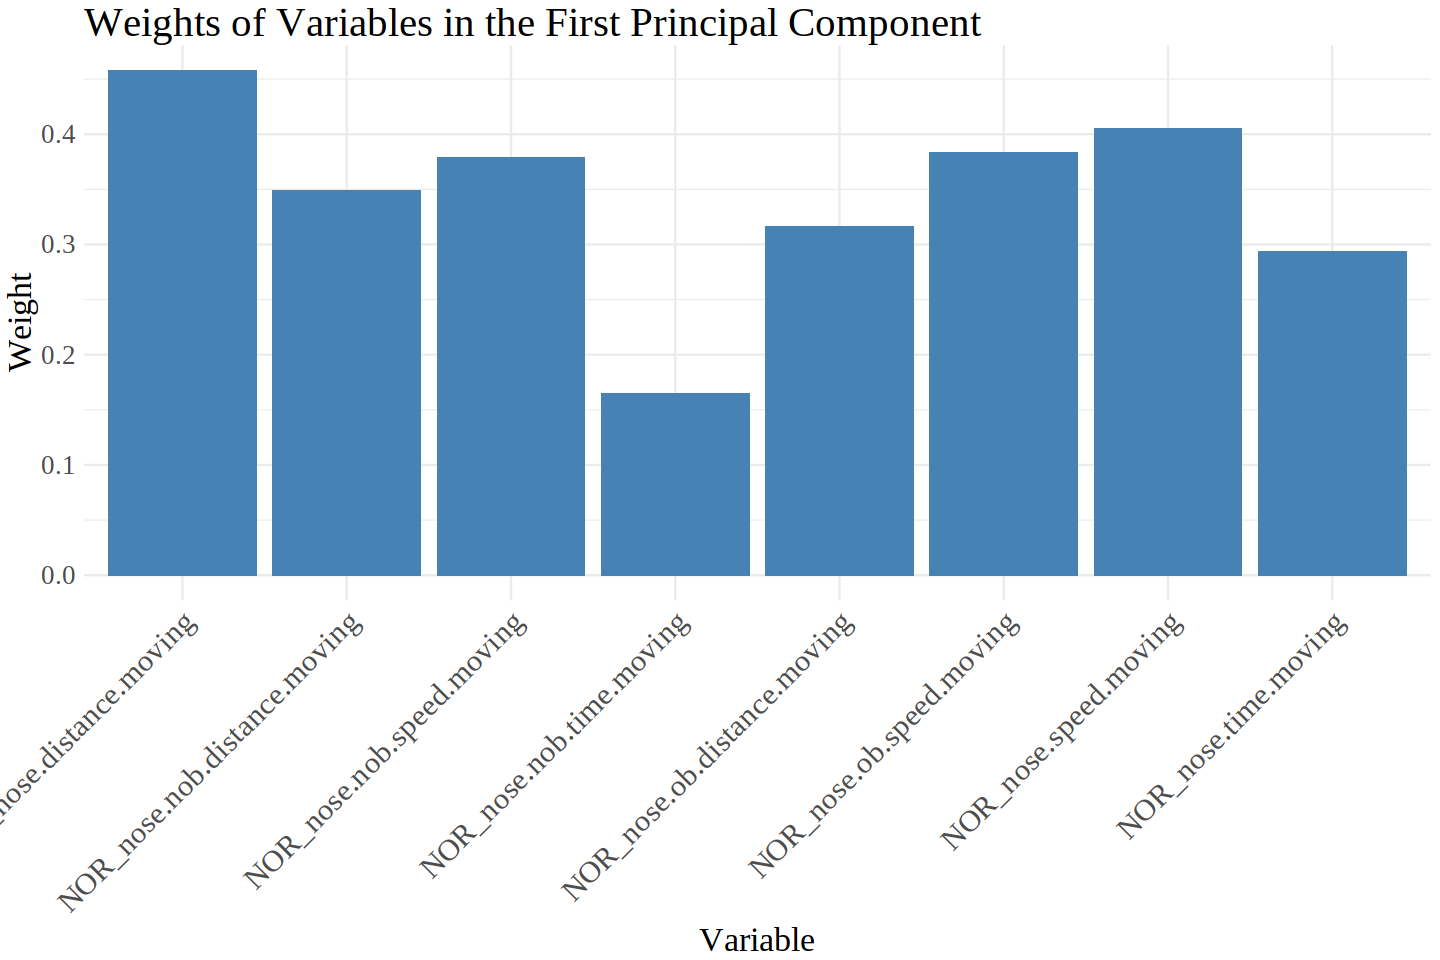

In [ ]:
result_Locomotion_NOR <- Behavior_metrics_4pca %>% 
    filter(Measure == "Locomotion_NOR") %>% 
    select(where(~ !any(is.na(.)))) 
    
pca_result_Locomotion_NOR <- prcomp(select(result_Locomotion_NOR, -c(RID, relative_jacobian, Measure)), scale. = TRUE)

pca_Locomotion_NOR_explained_variance <- pca_result_Locomotion_NOR$sdev^2 / sum(pca_result_Locomotion_NOR$sdev^2)

# Create a data frame for plotting
pca_Locomotion_NOR_explained_variance_df <- data.frame(
    Component = factor(1:length(pca_Locomotion_NOR_explained_variance)),
    Variance = pca_Locomotion_NOR_explained_variance
)

# # Plot the variance explained by each component
# ggplot(pca_Locomotion_NOR_explained_variance_df, aes(x = Component, y = Variance)) +
#     geom_bar(stat = "identity", fill = "steelblue") +
#     labs(title = "Variance Explained by Each Principal Component",
#              x = "Principal Component",
#              y = "Variance Explained") +
#     theme_minimal() +
#     theme_settings

# # Plot the cumulative variance explained
# ggplot(pca_Locomotion_NOR_explained_variance_df, aes(x = Component, y = cumsum(Variance))) +
#     geom_line(color = "steelblue", size = 1) +
#     geom_point(color = "steelblue", size = 3) +
#     labs(title = "Cumulative Variance Explained by Principal Components",
#              x = "Principal Component",
#              y = "Cumulative Variance Explained") +
#     theme_minimal() +
#     theme_settings

# Plot the weights of each variable in the first and second component using ggplot2
pca_Locomotion_NOR_weights_df <- data.frame(
    Variable = rownames(pca_result_Locomotion_NOR$rotation),
    First_Component = pca_result_Locomotion_NOR$rotation[, 1],
    Second_Component = pca_result_Locomotion_NOR$rotation[, 2]
)

ggplot(pca_Locomotion_NOR_weights_df, aes(x = Variable, y = First_Component)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(title = "Weights of Variables in the First Principal Component",
             x = "Variable",
             y = "Weight") +
    theme_minimal() +
    theme_settings +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


pca_result_Locomotion_NOR_first_component <- result_Locomotion_NOR %>% select(c("RID","Measure")) %>% 
    add_column(Locomotion_NOR = pca_result_Locomotion_NOR$x[, which.max(pca_Locomotion_NOR_explained_variance)]) %>%  
    select(-c(Measure))

pca_result_Locomotion_NOR_second_component <- result_Locomotion_NOR %>% select(c("RID","Measure")) %>% 
    add_column(Locomotion_NOR2 = pca_result_Locomotion_NOR$x[, 2]) %>%  
    select(-c(Measure))

#### Component "Memoria"

In [ ]:
result_Memoria <- Behavior_metrics_4pca %>% 
    filter(Measure == "Memoria") %>% 
    select(where(~ !any(is.na(.)))) 
    
pca_result_Memoria <- prcomp(select(result_Memoria, -c(RID, relative_jacobian, Measure)), scale. = TRUE)

pca_Memoria_explained_variance <- pca_result_Memoria$sdev^2 / sum(pca_result_Memoria$sdev^2)

# Create a data frame for plotting
pca_Memoria_explained_variance_df <- data.frame(
    Component = factor(1:length(pca_Memoria_explained_variance)),
    Variance = pca_Memoria_explained_variance
)

# # Plot the variance explained by each component
# ggplot(pca_Memoria_explained_variance_df, aes(x = Component, y = Variance)) +
#     geom_bar(stat = "identity", fill = "steelblue") +
#     labs(title = "Variance Explained by Each Principal Component",
#              x = "Principal Component",
#              y = "Variance Explained") +
#     theme_minimal() +
#     theme_settings

# # Plot the cumulative variance explained
# ggplot(pca_Memoria_explained_variance_df, aes(x = Component, y = cumsum(Variance))) +
#     geom_line(color = "steelblue", size = 1) +
#     geom_point(color = "steelblue", size = 3) +
#     labs(title = "Cumulative Variance Explained by Principal Components",
#              x = "Principal Component",
#              y = "Cumulative Variance Explained") +
#     theme_minimal() +
#     theme_settings

# Plot the weights of each variable in the first and second component using ggplot2
pca_Memoria_weights_df <- data.frame(
    Variable = rownames(pca_result_Memoria$rotation),
    First_Component = pca_result_Memoria$rotation[, 1],
    Second_Component = pca_result_Memoria$rotation[, 2]
)

# ggplot(pca_Memoria_weights_df, aes(x = Variable, y = First_Component)) +
#     geom_bar(stat = "identity", fill = "steelblue") +
#     labs(title = "Weights of Variables in the First Principal Component",
#              x = "Variable",
#              y = "Weight") +
#     theme_minimal() +
#     theme_settings +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1))

pca_result_Memoria_first_component <- result_Memoria %>% select(c("RID","Measure")) %>% 
    add_column(Memoria = pca_result_Memoria$x[, which.max(pca_Memoria_explained_variance)]) %>%  
    select(-c(Measure))
    
pca_result_Memoria_second_component <- result_Memoria %>% select(c("RID","Measure")) %>% 
    add_column(Memoria2 = pca_result_Memoria$x[, 2]) %>%  
    select(-c(Measure))

#### Alcohol consumption

In [ ]:
Behavior_metrics <- pca_result_Memoria_first_component %>%
    left_join(pca_result_Locomotion_NOR_first_component) %>% 
    left_join(pca_result_Locomotion_NOR_second_component) %>% 
    left_join(pca_result_locomotor_EPM_first_component) %>%
    left_join(pca_result_locomotor_EPM_second_component) %>%
    left_join(pca_result_Anxiety_first_component) %>%
    left_join(General_intake %>% filter(Session == 20, Phase == "Model", Bottle == "EtOH") %>% 
    select(RID,Sex,Group,Weight_kg, main_intake) %>% 
    mutate(main_intake = case_when(main_intake <=12 ~ main_intake ))   %>%
    mutate(RID = str_replace_all(RID,"-0","-"), 
           main_intake = case_when(Group == "Ctrl" ~ 0,
                                   Group == "Alc" ~ main_intake,
                                   Group == "Str" ~ 0,
                                   Group == "Alc+Str" ~ main_intake),
            Weight_kg = case_when(RID == "sub-124" ~ 0.404, 
                RID == "sub-128" ~ 0.434,
                RID == "sub-134" ~ 0.430,
                RID == "sub-135" ~ 0.495,
                TRUE ~ Weight_kg) )
     ) %>% unique() %>%
     mutate(main_intake = case_when(is.na(main_intake) ~ 0, TRUE ~ main_intake))
    

Joining with `by = join_by(RID)`
Joining with `by = join_by(RID)`
Joining with `by = join_by(RID)`
Joining with `by = join_by(RID)`
Joining with `by = join_by(RID)`
Adding missing grouping variables: `Bottle`
Joining with `by = join_by(RID)`


### Joint

In [ ]:
Behavior_metrics %>% select(-c(Sex,Bottle)) %>% left_join(Behavior_metrics_4pca %>% 
        filter(relative_jacobian != "/data/chamal/projects/jalilr/pls/mice_data/relative_jacobians/nii/t3_pls/NA") %>% 
    select(RID,relative_jacobian)) %>% unique() %>%
    select(RID,Group,relative_jacobian,Memoria,Anxiety,Locomotion_NOR,Locomotion_NOR2,Locomotor_EPM,Locomotor_EPM2,Weight_kg,main_intake) %>%
    drop_na() %>% write_csv("Data/Behavior/PLS_preparation/DLC_tracked_4pls_path.csv")

Joining with `by = join_by(RID)`


In [ ]:
behavior_smri_metrics <- Volumes_jacobians %>% 
    left_join(Behavior_metrics %>% 
    mutate(Ctrl1 = case_when(Group == "Ctrl" ~ 1, TRUE ~ 0),
        Alc1 = case_when(Group == "Alc" ~ 1, TRUE ~ 0),
        Str1 = case_when(Group == "Str" ~ 1, TRUE ~ 0),
        AlcStr1 = case_when(Group == "Alc+Str" ~ 1, TRUE ~ 0), .before = 3) %>% 
        mutate(RID = str_replace(RID, "-0", "-"))) %>% 
    filter(Session == "ses-T3") %>% drop_na() %>% unique()

Joining with `by = join_by(RID, Group, Sex)`


In [ ]:
smri_z <- behavior_smri_metrics %>% dplyr::select(contains(c("left_","right_"),ignore.case = F)) %>% 
    scale(center = TRUE, scale = TRUE)
behavior_z <- behavior_smri_metrics %>% dplyr::select(contains(c("EPM","NOR"),ignore.case = F)) %>% 
    scale(center = TRUE, scale = TRUE)

## **3. Multivariate analysis (PLS)** MATLAB

1. sMRI - Behavior

### Load data

In [23]:
# pls_mat <- read.mat("Data/PLS/PLS.mat")

In [24]:
# PLS_results <- pls_mat$result

In [25]:
# save(PLS_results,file = "Data/PLS/PLS.RData")

In [26]:
load("Data/PLS/PLS.RData")

In [27]:
s_PLS_results <- tibble(s = PLS_results$s) %>% unnest()

pct_cov <- s_PLS_results %>% 
    mutate(pct_cov = (s^2)/sum(s^2), 
        x = 1:nrow(s_PLS_results))

In [28]:
p_variance <- pct_cov %>% mutate(sprob = PLS_results$perm_result$sprob %>% unlist())

In [29]:
Split_half_vals <- tibble(CorrU = PLS_results$perm_splithalf$orig_ucorr %>% unlist(),CorrV = PLS_results$perm_splithalf$orig_vcorr %>% unlist(),
    P_valueU = PLS_results$perm_splithalf$ucorr_prob %>% unlist(), P_valueV = PLS_results$perm_splithalf$vcorr_prob %>% unlist(),
    Ucorr_lower = PLS_results$perm_splithalf$ucorr_ll %>% unlist(), Ucorr_upper = PLS_results$perm_splithalf$ucorr_ul %>% unlist(),
    Vcorr_lower = PLS_results$perm_splithalf$vcorr_ll %>% unlist(), Vcorr_upper = PLS_results$perm_splithalf$vcorr_ul %>% unlist(),
    Ucorr = PLS_results$perm_splithalf$ucorr %>% unlist(), Vcorr = PLS_results$perm_splithalf$vcorr %>% unlist(),
    LV = factor(paste0("LV ",1:8),levels = paste0("LV ",1:8))
    )

### Visualization

#### Significance, Reproducibility

In [30]:
# Define colors
color_left <- "black"
color_right <- "#BD4885"

# Plot
p_value_plot <- p_variance %>% ggplot(x = x) +
  geom_point(aes(x = x, y = pct_cov), color = color_left, size = 2) +
  geom_line(aes(x = x, y = pct_cov), color = color_left, linewidth = 1) +
  geom_point(aes(x = x, y = sprob), color = color_right, size = 3) +  # Scale sprob to align with second y-axis
  geom_line(aes(x = x, y = sprob), color = color_right, linewidth = 1) +
  scale_y_continuous(
    name = "Variance Explained",
    sec.axis = sec_axis(~ . * 1 , name = "p-value")  # Inverse of scaling
  ) +
  scale_x_continuous(limits = c(1, 10), breaks = c(1, 5, 10)) +
  labs(x = "Latent Variables") +
  theme_ggdist(base_size = 15) +
  theme_settings +
  theme(
    axis.title.y.left = element_text(color = color_left),
    axis.title.y.right = element_text(color = color_right),
    panel.grid.major = element_blank(),  
    panel.grid.minor = element_blank()
  ) + 
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "gray", size = 1.1)


In [31]:
plot_splithalf_Corr_U <- ggplot(Split_half_vals, aes(x = LV, y = CorrU)) +
   geom_point(color = ifelse(Split_half_vals$P_valueU < 0.05, "#BD4885", "skyblue4"), size = 3) +
   geom_errorbar(aes(ymin = Ucorr_lower, ymax = Ucorr_upper), width = 0.2, color = "gray") +
   geom_hline(yintercept = 0, color = 1, lwd = 0.5) +
#   # geom_text(aes(label = names, # Text with groups
#   #               hjust = ifelse(scores < 0, 1.5, -1),
#   #               vjust = 0.5), size = 2.5) +
   coord_flip() +
   labs(y = "Brain-Correlation", x = "Latent Variables") +
   theme_ggdist() +
   theme_settings +
   theme(axis.line.x = element_line(colour = "black"),
         axis.title.y = element_blank(),  
         panel.grid.minor.x = element_blank(),  
         panel.grid.major.x = element_blank(), 
         panel.grid.minor.y = element_blank(), 
         panel.grid.major.y = element_blank())

plot_splithalf_Corr_V <- ggplot(Split_half_vals, aes(x = LV, y = CorrV)) +
   geom_point(color = ifelse(Split_half_vals$P_valueV < 0.05, "#BD4885", "skyblue4"), size = 3) +
   geom_errorbar(aes(ymin = Vcorr_lower, ymax = Vcorr_upper), width = 0.2, color = "gray") +
   geom_hline(yintercept = 0, color = 1, lwd = 0.5) +
#   # geom_text(aes(label = names, # Text with groups
#   #               hjust = ifelse(scores < 0, 1.5, -1),
#   #               vjust = 0.5), size = 2.5) +
   coord_flip() +
   labs(y = "Behavior-Correlation", x = "Latent Variables") +
   theme_ggdist() +
   theme_settings +
   theme(axis.line.x = element_line(colour = "black"),
         axis.title.y = element_blank(),  
         panel.grid.minor.x = element_blank(),  
         panel.grid.major.x = element_blank(), 
         panel.grid.minor.y = element_blank(), 
         panel.grid.major.y = element_blank())

In [32]:
Figure6_first <- wrap_plots(p_value_plot + plot_splithalf_Corr_U + plot_splithalf_Corr_V)

#### Plotting LVs

In [33]:
options(repr.plot.width=10, repr.plot.height=8) # to resize plots

# Define colors
color_demo <- rgb(31/255, 119/255, 180/255)
color_behavtest1 <- rgb(255/255, 219/255, 88/255)
color_behavtest2 <- rgb(255/255, 127/255, 14/255)
color_gray <- rgb(137/255, 137/255, 137/255)
width <- 0.9

# Example data (replace with your actual data)
result_corrs <- list(
  lvcorrs = as.matrix(PLS_results$lvcorrs %>% reduce(cbind)),
  boot_result = list(
    ulcorr = as.matrix(PLS_results$boot_result$ulcorr %>% reduce(cbind)),
    llcorr = as.matrix(PLS_results$boot_result$llcorr %>% reduce(cbind))
  )
)
Behavior_names <- Behavior_metrics %>% 
    # mutate(Ctrl1 = case_when(Group == "Ctrl" ~ 1, TRUE ~ 0),
    #     Alc1 = case_when(Group == "Alc" ~ 1, TRUE ~ 0),
    #     Str1 = case_when(Group == "Str" ~ 1, TRUE ~ 0),
    #     AlcStr1 = case_when(Group == "Alc+Str" ~ 1, TRUE ~ 0), .before = 3) %>% 
    select(-c(RID,Bottle,Group,Sex)) %>% colnames() %>% 
      gsub("_bodycentre", "", .) %>% 
      gsub("_nose", "", .) %>% 
      gsub("_", " ", .) %>% 
      gsub("\\.", " ", .) 

which_lv <- 2

lv <- data.frame(
  names = Behavior_names,
  scores = result_corrs$lvcorrs[, which_lv],
  upper = result_corrs$boot_result$ulcorr[, which_lv] - result_corrs$lvcorrs[, which_lv],
  lower = result_corrs$lvcorrs[, which_lv] - result_corrs$boot_result$llcorr[, which_lv]
  ) %>% set_rownames(Behavior_names)

color <- lv %>% mutate(color = ifelse(lv$scores < 0, "#4089d1", "#d14040"),
    color = ifelse(abs(lv$scores) < abs(lv$lower) & abs(lv$scores) < abs(lv$upper), "#a0a3a6", color),
    color = case_when(names == "NOR PI entries" ~ "#a0a3a6", TRUE ~ color)) %>% select(color) %>% pull()

plot_LV_behavior <- ggplot(lv, aes(x = reorder(names, scores), y = scores)) +
  geom_bar(stat = "identity",
          show.legend = FALSE,
          fill = color,     
          color = "black") +
  geom_errorbar(aes(ymin = scores - lower, ymax = scores + upper), width = 0.2, color = "black") +
  geom_hline(yintercept = 0, color = 1, lwd = 0.5) +
  # geom_text(aes(label = names, # Text with groups
  #               hjust = ifelse(scores < 0, 1.5, -1),
  #               vjust = 0.5), size = 2.5) +
  ylab("LV2 BSR") +
  coord_flip() +
  theme_ggdist(base_size = 15) +
  theme_settings +
  theme(axis.line.x = element_line(colour = "black"),
        axis.title.y = element_blank(),  
        panel.grid.minor.x = element_blank(),  
        panel.grid.major.x = element_blank(), 
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank()) # Remove horizontal grid

#### Plotting and calculate brain-behavior scores

In [34]:
loadings_LV2 <- Behavior_metrics %>% drop_na() %>%
    add_column( tibble(
    brainsc_dataLV2 = read_csv("Data/PLS/brainsc_dataLV2.csv", col_names = FALSE) %>% c(),
    behavsc_dataLV2 = read_csv("Data/PLS/behavsc_dataLV2.csv", col_names = FALSE) %>% c()) %>% 
    unnest())

Rows: 61 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 61 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [35]:
options(repr.plot.width=10, repr.plot.height=10) # to resize plots
loadings_LV2_tibble <- loadings_LV2 %>% select(-Group) %>% left_join(Volumes_jacobians %>% select(RID,Group) %>% unique(), by = "RID") %>% 
    mutate(Group = factor(Group, levels = c("Ctrl","Alc","Str","Alc+Str"))) %>% 
    mutate(Group = case_when(Group == "Ctrl" ~ "EtOH-/CRS-", Group == "Alc" ~ "EtOH+/CRS-", 
        Group == "Str" ~ "EtOH-/CRS+",Group == "Alc+Str" ~ "EtOH+/CRS+"),
        Group = factor(Group, levels = c("EtOH-/CRS-", "EtOH+/CRS-", "EtOH-/CRS+", "EtOH+/CRS+"))) 
        
Cor_Behavior_Brain <- loadings_LV2_tibble %>% 
    ggplot(aes(x = brainsc_dataLV2, y = behavsc_dataLV2, color = Group)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    labs(x = "Brain scores", y = "Behavior scores") +
    ylim(-6.5, 8.5) +
    xlim(-17, 10) +
    theme_ggdist() +
    scale_color_manual(values = pal_group) +
    theme_settings +
    theme(axis.title.x = element_text(size = 25),
        axis.title.y = element_text(size = 25))

Test_Brain <- loadings_LV2_tibble %>% select(brainsc_dataLV2, behavsc_dataLV2, Group, Sex) %>%
    ggplot(aes(x = Group, y = brainsc_dataLV2, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Brain Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.2
    ) +
    ylim(-17, 10) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

Test_Behavior <- loadings_LV2_tibble %>% select(brainsc_dataLV2, behavsc_dataLV2, Group, Sex) %>%
    ggplot(aes(x = Group, y = behavsc_dataLV2, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Behavior Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
    ggpubr::geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    ylim(-6.5, 8.5) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

part_1 <- (Cor_Behavior_Brain +
    theme(legend.position = "none") + Test_Behavior +
    theme(axis.line.x = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) +
    plot_layout(widths = c(1.5,0.5),ncol = 2, nrow = 1)

part_2 <- plot_spacer() + (Test_Brain + coord_flip() +
    theme(axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) + plot_spacer() +
    plot_layout(widths = c(0.11,1.5,0.5))

plot_scores_both <- wrap_elements(part_2) + wrap_elements(part_1) + 
    plot_layout(ncol = 1, nrow = 2, heights = c(0.5,1.5))

In [36]:
options(repr.plot.width=10, repr.plot.height=10) # to resize plots
loadings_LV2_tibble_female <- loadings_LV2 %>% select(-Group) %>% left_join(Volumes_jacobians %>% select(RID,Group) %>% unique(), by = "RID") %>% 
    mutate(Group = factor(Group, levels = c("Ctrl","Alc","Str","Alc+Str"))) %>% 
    mutate(Group = case_when(Group == "Ctrl" ~ "EtOH-/CRS-", Group == "Alc" ~ "EtOH+/CRS-", 
        Group == "Str" ~ "EtOH-/CRS+",Group == "Alc+Str" ~ "EtOH+/CRS+"),
        Group = factor(Group, levels = c("EtOH-/CRS-", "EtOH+/CRS-", "EtOH-/CRS+", "EtOH+/CRS+"))) %>% 
        filter(Sex == "female")
        
Cor_Behavior_Brain_female <- loadings_LV2_tibble_female %>% 
    ggplot(aes(x = brainsc_dataLV2, y = behavsc_dataLV2, color = Group)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    labs(x = "Brain scores", y = "Behavior scores") +
    xlim(-17, 10) +
    ylim(-6.5, 8.5) +
  theme_ggdist(base_size = 15) +
    scale_color_manual(values = pal_group) +
    theme_settings  +
    theme(axis.title.x = element_text(size = 25),
        axis.title.y = element_text(size = 25))

Test_Brain_female <- loadings_LV2_tibble_female %>% select(brainsc_dataLV2, behavsc_dataLV2, Group, Sex) %>%
    ggplot(aes(x = Group, y = brainsc_dataLV2, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Brain Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",   
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    ylim(-17, 10) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

Test_Behavior_female <- loadings_LV2_tibble_female %>% select(brainsc_dataLV2, behavsc_dataLV2, Group, Sex) %>%
    ggplot(aes(x = Group, y = behavsc_dataLV2, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Behavior Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr", 
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    ylim(-6.5, 8.5) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

part_1_female <- (Cor_Behavior_Brain_female +
    theme(legend.position = "none") + Test_Behavior_female +
    theme(axis.line.x = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) +
    plot_layout(widths = c(1.5,0.5),ncol = 2, nrow = 1)

part_2_female <- plot_spacer() + (Test_Brain_female + coord_flip() +
    theme(axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) + plot_spacer() +
    plot_layout(widths = c(0.1,1.5,0.5))

plot_scores_females <- wrap_elements(part_2_female) + wrap_elements(part_1_female) + 
    plot_layout(ncol = 1, nrow = 2, heights = c(0.5,1.5))

In [37]:
options(repr.plot.width=10, repr.plot.height=10) # to resize plots
loadings_LV2_tibble_male <- loadings_LV2  %>% select(-Group) %>% left_join(Volumes_jacobians %>% select(RID,Group) %>% unique(), by = "RID") %>% 
    mutate(Group = factor(Group, levels = c("Ctrl","Alc","Str","Alc+Str"))) %>% 
    mutate(Group = case_when(Group == "Ctrl" ~ "EtOH-/CRS-", Group == "Alc" ~ "EtOH+/CRS-", 
        Group == "Str" ~ "EtOH-/CRS+",Group == "Alc+Str" ~ "EtOH+/CRS+"),
        Group = factor(Group, levels = c("EtOH-/CRS-", "EtOH+/CRS-", "EtOH-/CRS+", "EtOH+/CRS+"))) %>% 
        filter(Sex == "male")
        
Cor_Behavior_Brain_male <- loadings_LV2_tibble_male %>% 
    ggplot(aes(x = brainsc_dataLV2, y = behavsc_dataLV2, color = Group)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    labs(x = "Brain scores", y = "Behavior scores") +
    xlim(-17, 10) +
    ylim(-6.5, 8.5) +
  theme_ggdist(base_size = 15) +
    scale_color_manual(values = pal_group) +
    theme_settings  +
    theme(axis.title.x = element_text(size = 25),
        axis.title.y = element_text(size = 25))

Test_Brain_male <- loadings_LV2_tibble_male %>% select(brainsc_dataLV2, behavsc_dataLV2, Group, Sex) %>%
    ggplot(aes(x = Group, y = brainsc_dataLV2, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Brain Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    ylim(-17, 17) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

Test_Behavior_male <- loadings_LV2_tibble_male %>% select(brainsc_dataLV2, behavsc_dataLV2, Group, Sex) %>%
    ggplot(aes(x = Group, y = behavsc_dataLV2, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Behavior Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) +
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr", 
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    ylim(-6.5, 8.5) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

part_1_male <- (Cor_Behavior_Brain_male +
    theme(legend.position = "none") + Test_Behavior_male +
    theme(axis.line.x = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) +
    plot_layout(widths = c(1.5,0.5),ncol = 2, nrow = 1)

part_2_male <- plot_spacer() + (Test_Brain_male + coord_flip() +
    theme(axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) + plot_spacer() +
    plot_layout(widths = c(0.1,1.5,0.12))

plot_scores_males <- wrap_elements(part_2_male) + wrap_elements(part_1_male) + 
    plot_layout(ncol = 1, nrow = 2, heights = c(0.5,1.5))

#### Final figure

In [38]:
pca_contribution_locomotor_EPM <- fviz_contrib(pca_result_locomotor_EPM, choice = "var", axes = 1, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())

pca_contribution_Anxiety <- fviz_contrib(pca_result_Anxiety, choice = "var", axes = 1, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())
    
pca_contribution_Locomotion_NOR <- fviz_contrib(pca_result_Locomotion_NOR, choice = "var", axes = 1, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())

pca_contribution_Memoria <- fviz_contrib(pca_result_Memoria, choice = "var", axes = 1, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())


In [39]:
pca_contribution_locomotor_EPM2 <- fviz_contrib(pca_result_locomotor_EPM, choice = "var", axes = 2, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())

pca_contribution_Anxiety2 <- fviz_contrib(pca_result_Anxiety, choice = "var", axes = 2, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())
    
pca_contribution_Locomotion_NOR2 <- fviz_contrib(pca_result_Locomotion_NOR, choice = "var", axes = 2, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())

pca_contribution_Memoria2 <- fviz_contrib(pca_result_Memoria, choice = "var", axes = 2, top = 10,fill =  "#9389BE", color = "#9389BE") +
    theme_ggdist() +
    theme_settings  +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), title = element_blank())


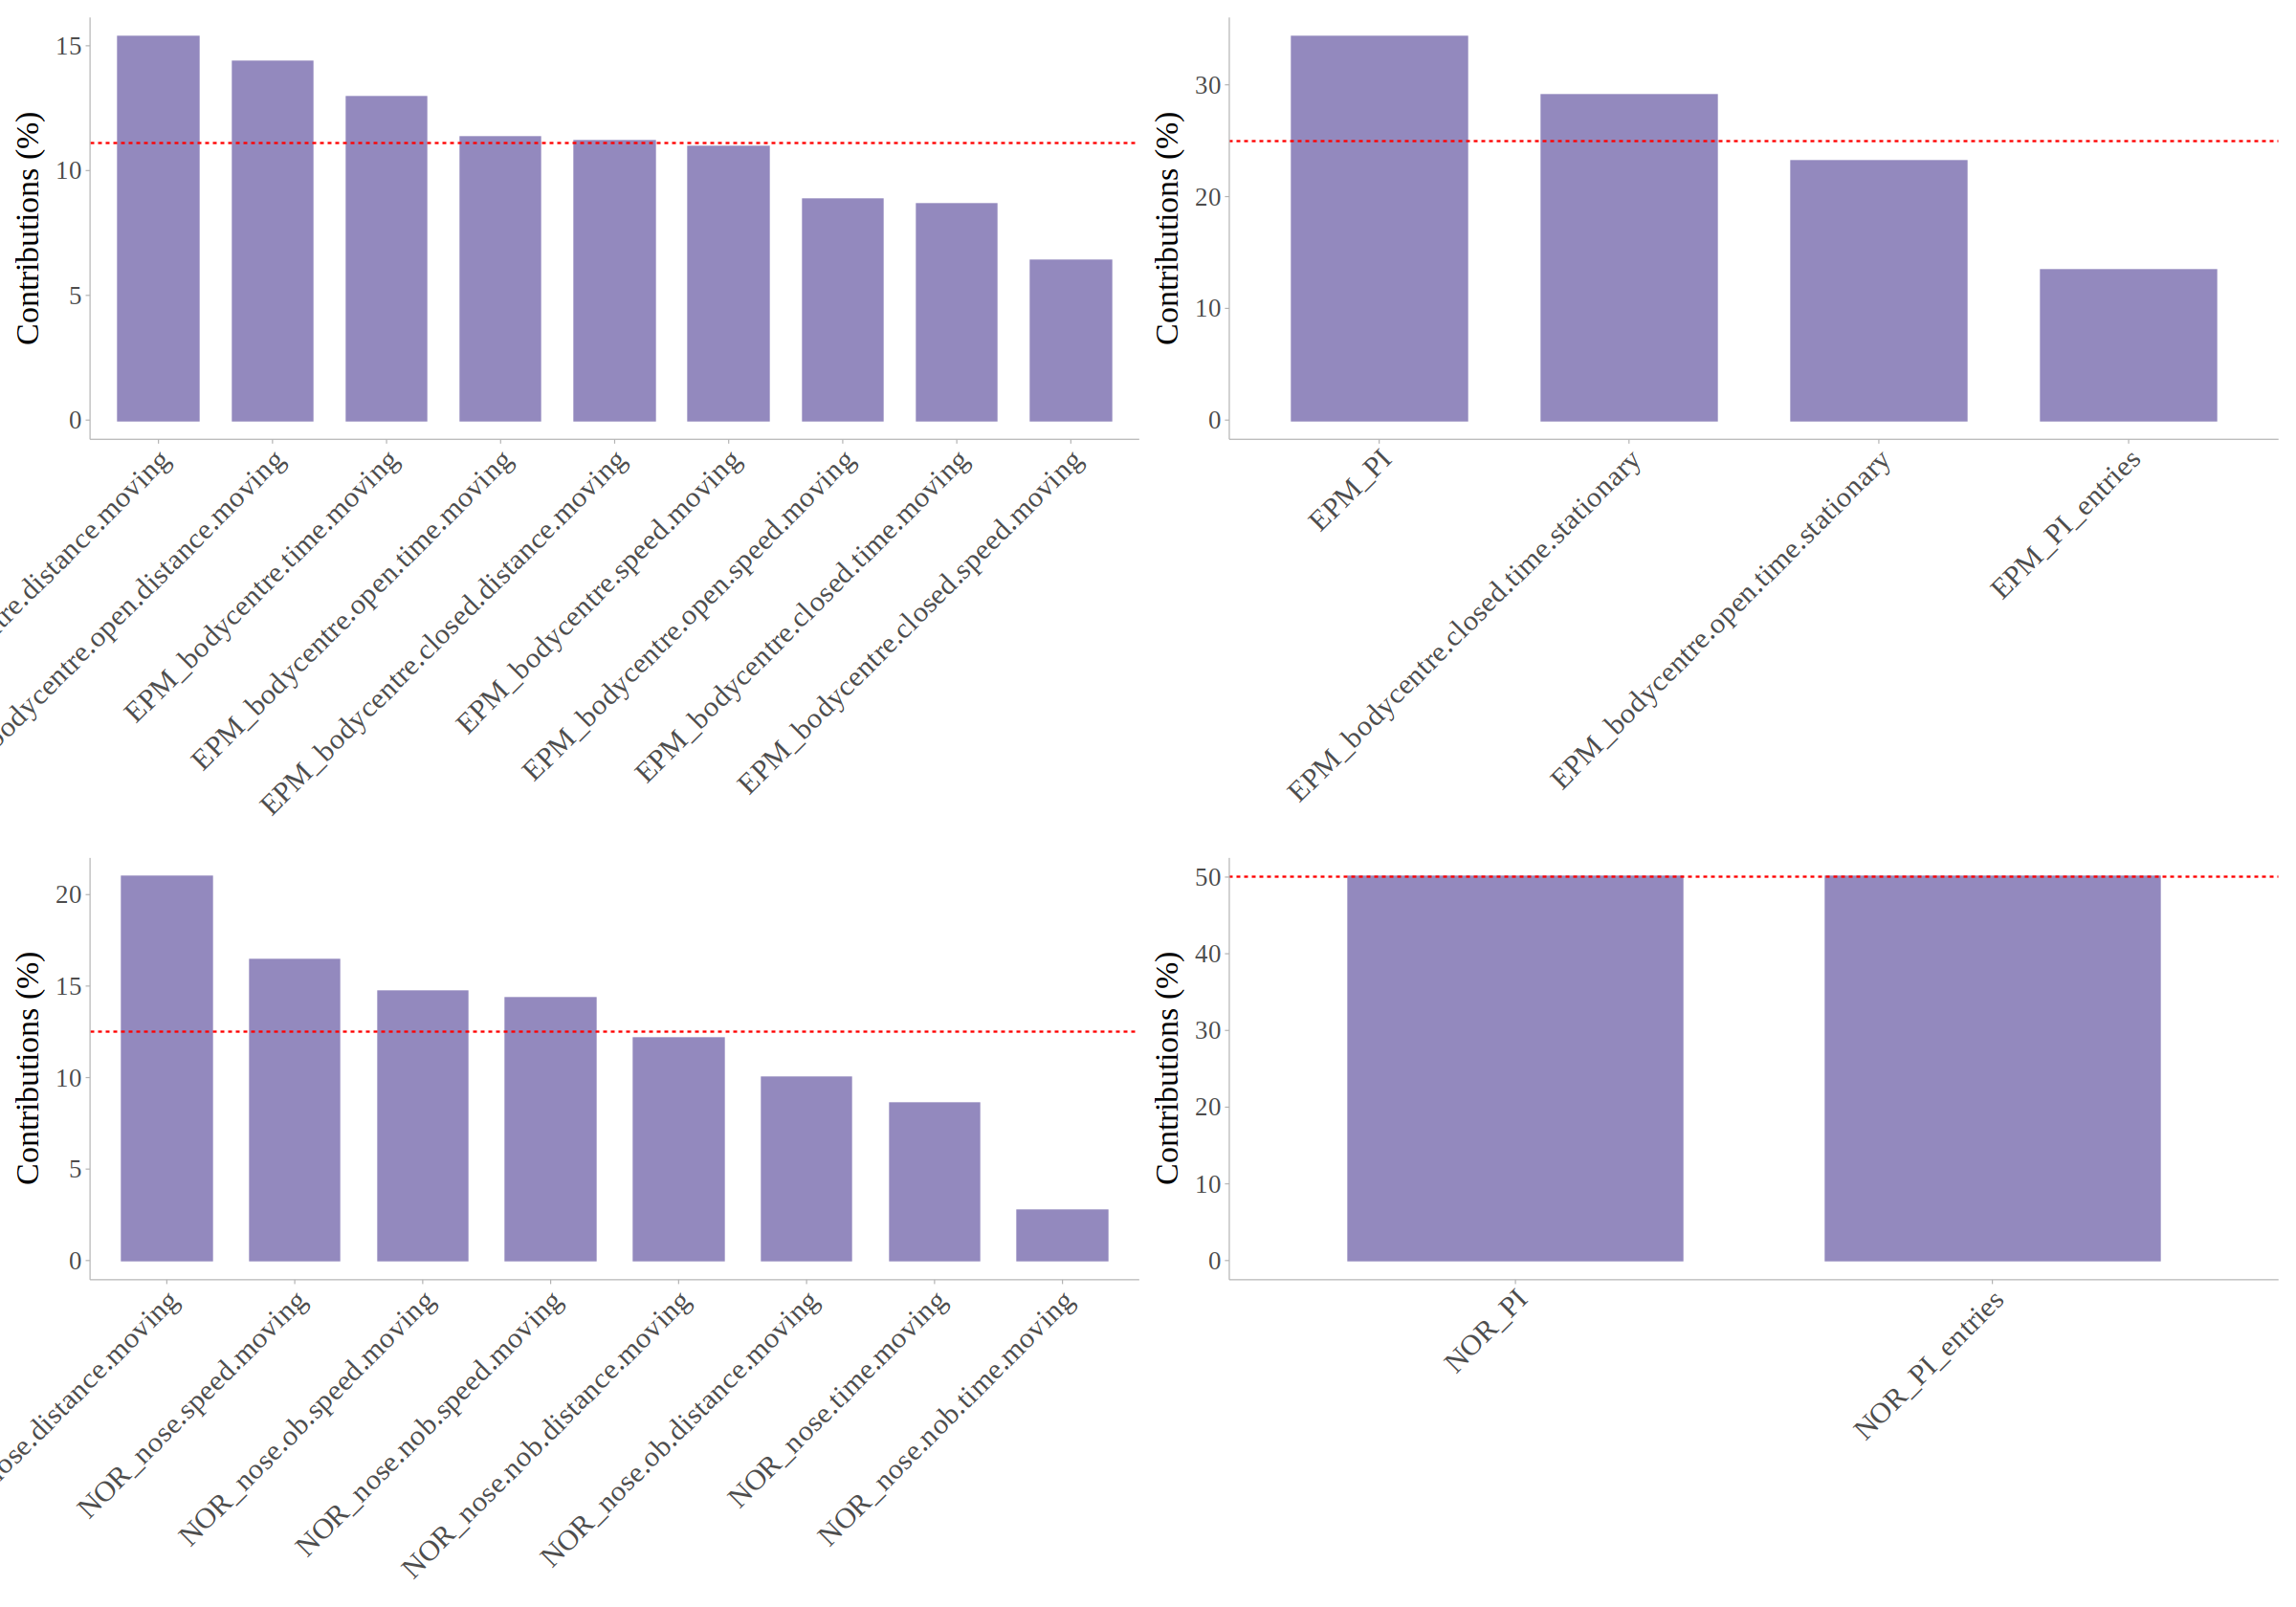

In [40]:
options(repr.plot.width=20, repr.plot.height=14) # to resize plots

pca_contribution_locomotor_EPM + pca_contribution_Anxiety + pca_contribution_Locomotion_NOR + pca_contribution_Memoria +
    plot_layout(ncol = 2, nrow = 2)

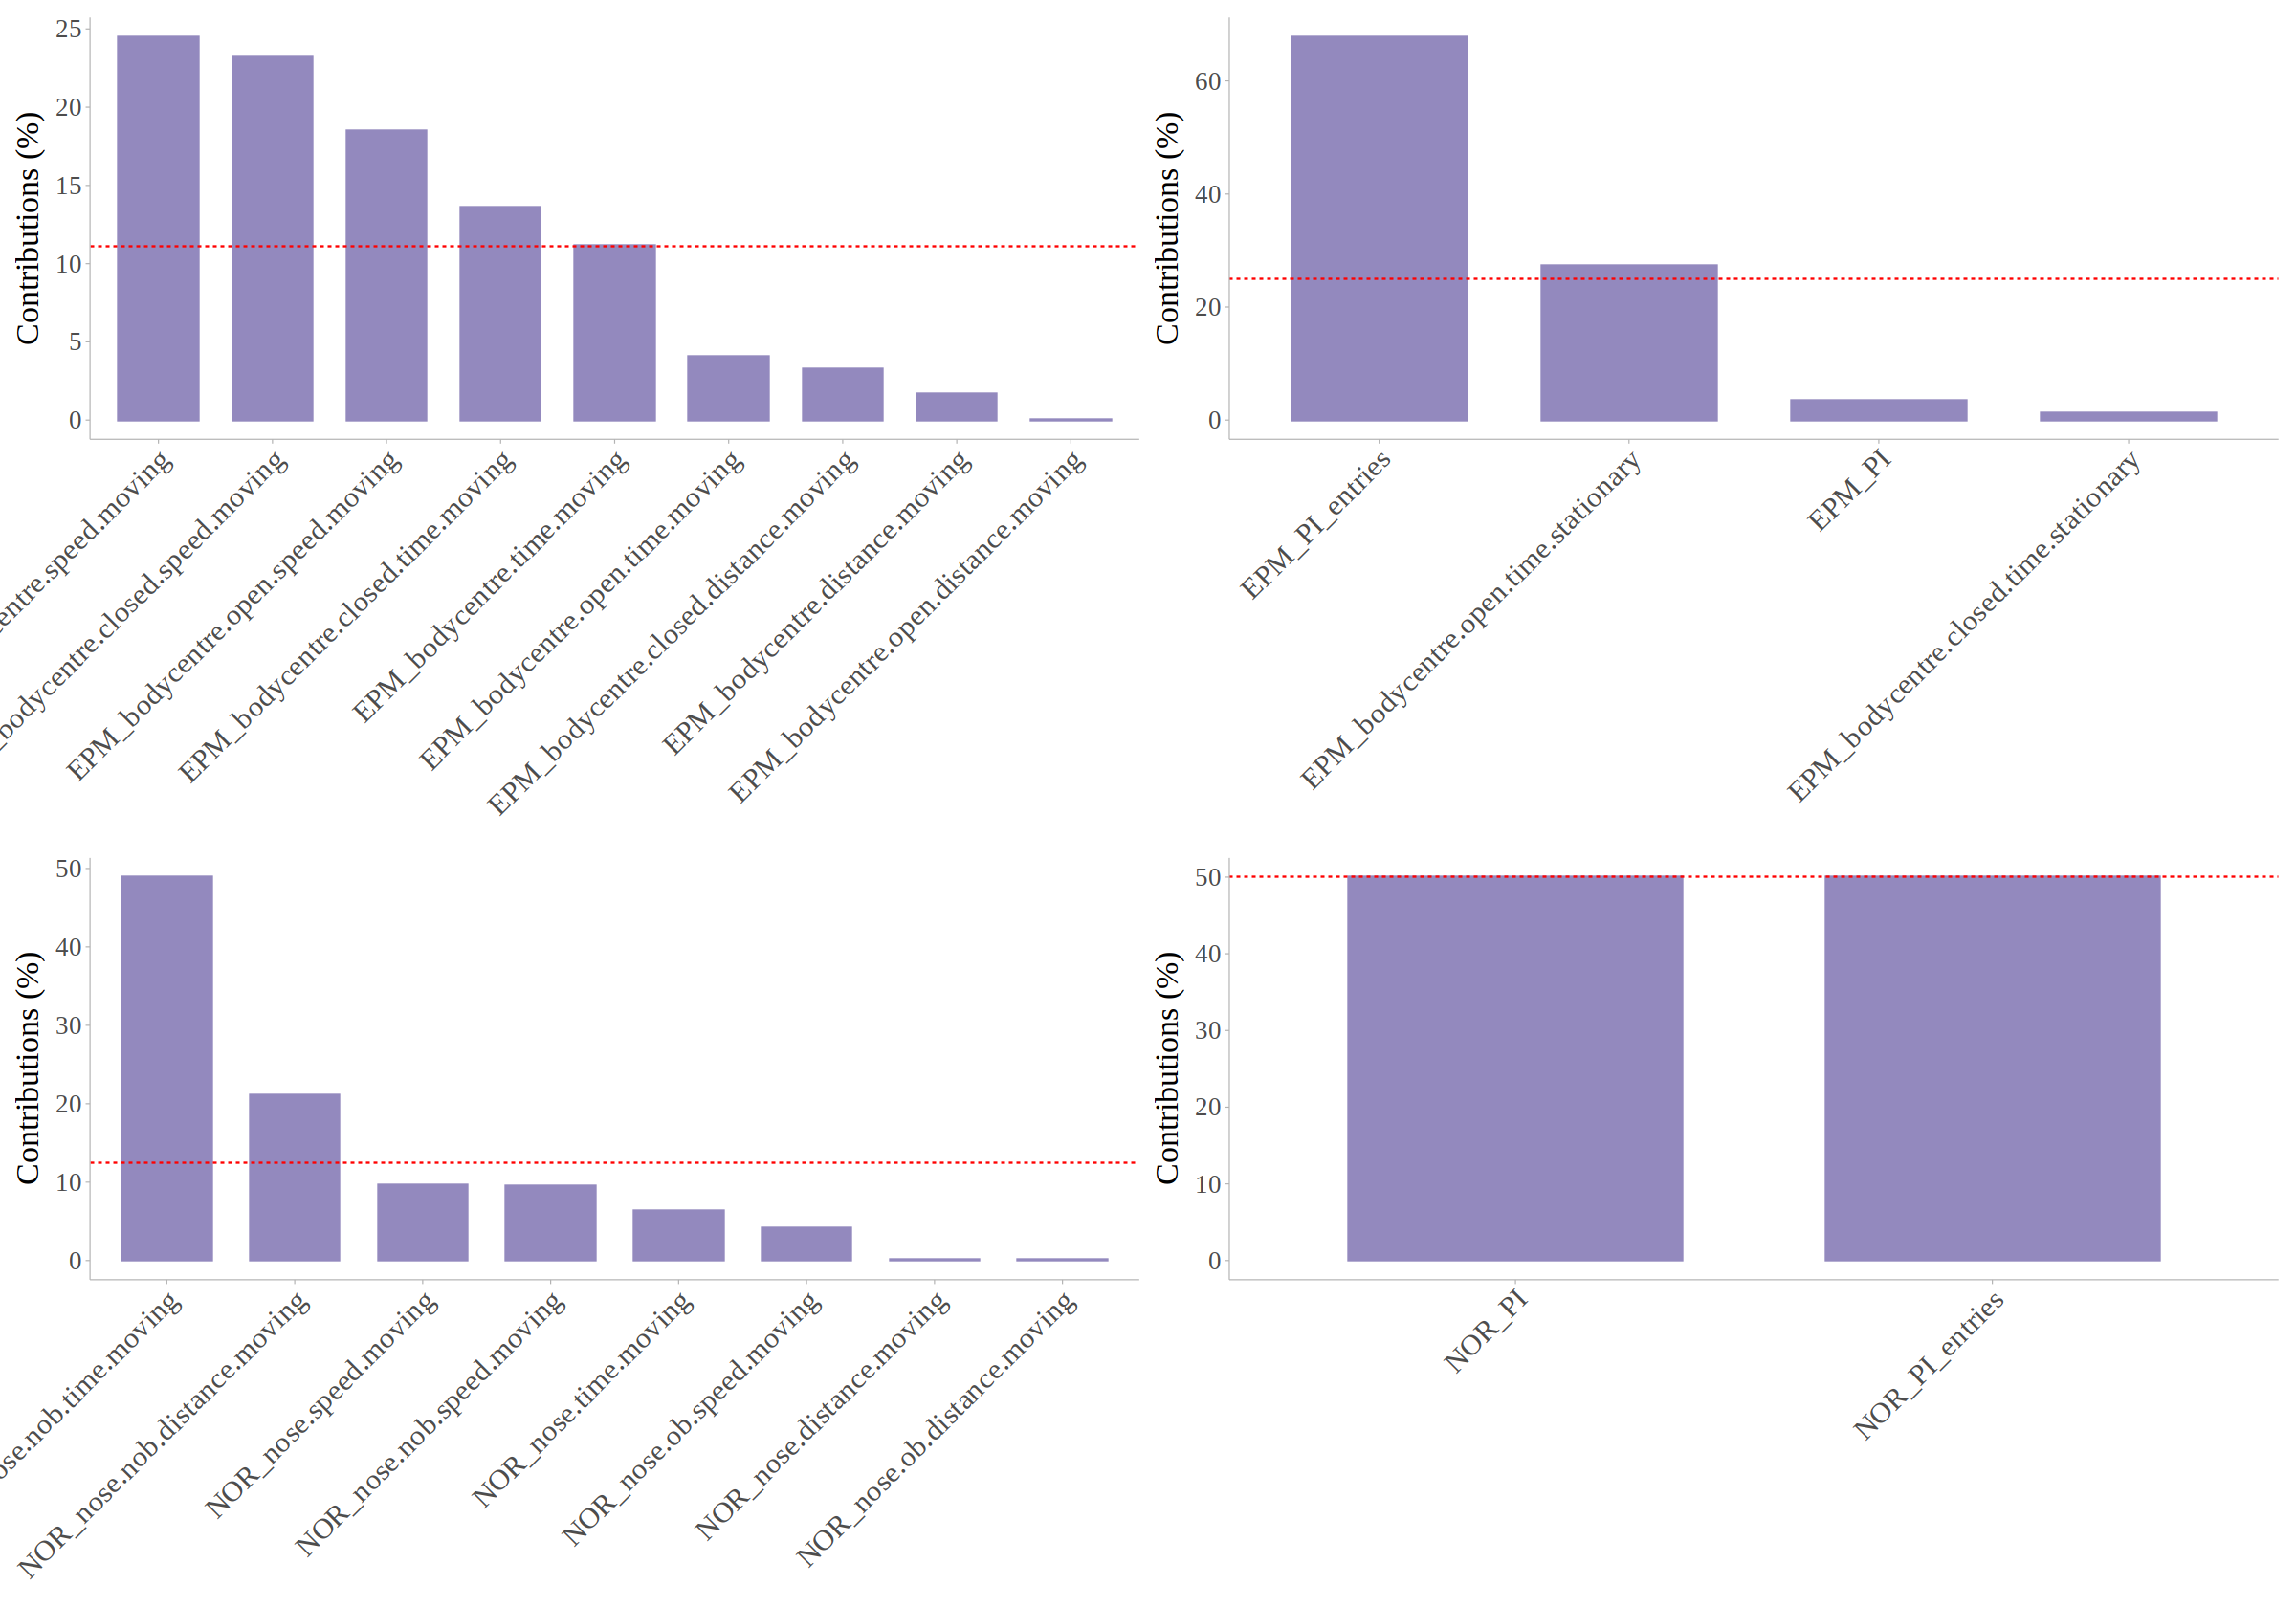

In [41]:
options(repr.plot.width=20, repr.plot.height=14) # to resize plots

pca_contribution_locomotor_EPM2 + pca_contribution_Anxiety2 + pca_contribution_Locomotion_NOR2 + pca_contribution_Memoria2 +
    plot_layout(ncol = 2, nrow = 2)

In [42]:
Figure6_firstRow <- wrap_plots(Figure6_first) + wrap_plots(plot_LV_behavior) +
    plot_layout(ncol = 2, nrow = 1, widths = c(0.8,0.2)) +
    plot_annotation(tag_levels = "a",tag_suffix = ")") &
    theme(plot.tag = element_text(size = 22, face = "bold")) 

In [43]:
plot_scores <- wrap_elements(plot_scores_both) + wrap_elements(plot_scores_males) + wrap_elements(plot_scores_females) +
    plot_annotation(theme = theme(plot.margin = margin(0, 0, 0, 0))) &
    theme(plot.tag = element_text(size = 22, face = "bold")) 

In [44]:
# Read png files
LV_maps_png <- readPNG("Figures/PLS/LV_maps.png")
LV_maps <- ggarrange(rasterGrob(LV_maps_png))


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


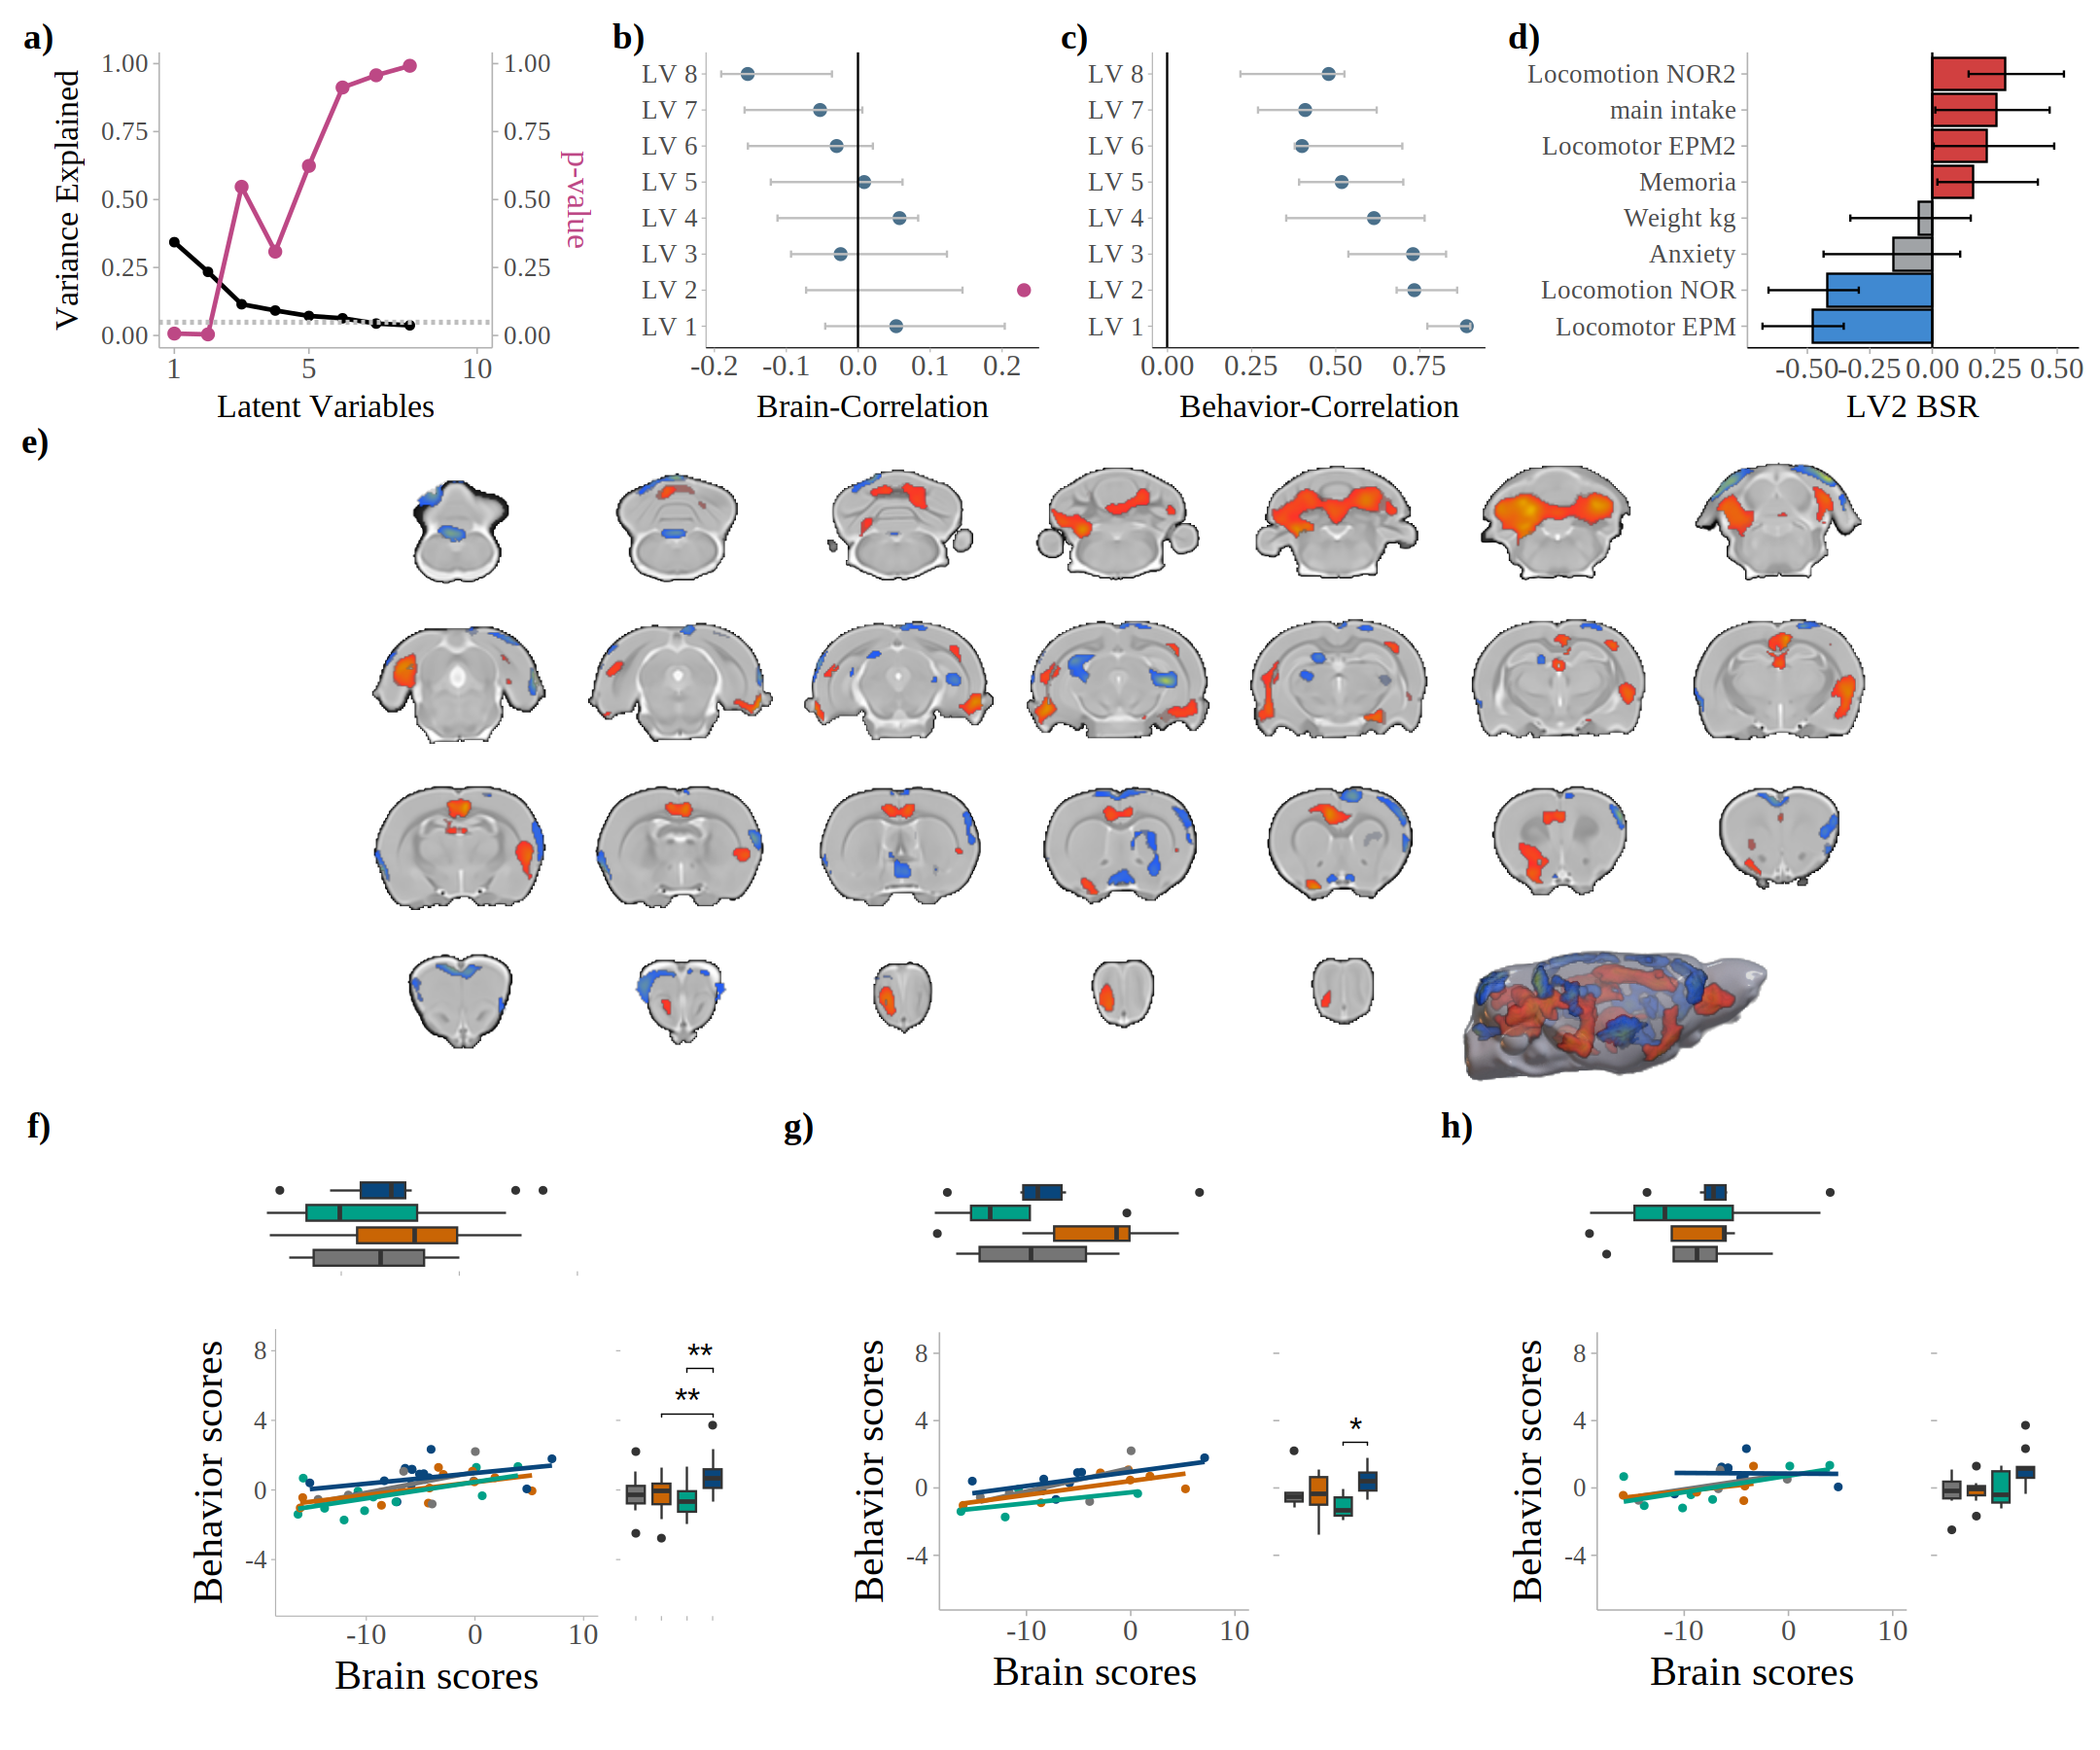

In [45]:
options(repr.plot.width=18, repr.plot.height=15) # to resize plots

wrap_plots(Figure6_firstRow) + wrap_plots(LV_maps) + wrap_plots(plot_scores) + 
    plot_layout(ncol = 1, nrow = 3, heights = c(0.2,0.45,0.4)) +
    plot_annotation(tag_levels = "a",tag_suffix = ")") &
    theme(plot.tag = element_text(size = 22, face = "bold", family = "Times New Roman"))

#### Saving

In [46]:
dir.create("Figures/PLS/",recursive = T, showWarnings = F)

In [47]:
ggsave(plot = p_value_plot, filename="Figures/PLS/p_value_plot.png",width = 7.5, height = 4.5, dpi = 300)
ggsave(plot = plot_LV_behavior, filename="Figures/PLS/LV_behavior.png",width = 8, height = 8.8, dpi = 300)

In [48]:
ggsave(plot = wrap_elements(plot_scores_both), filename="Figures/PLS/Brain_behavior_scores_both.png",
    width = 5, height = 5, dpi = 300)
ggsave(plot = wrap_elements(plot_scores_males), filename="Figures/PLS/Brain_behavior_scores_males.png",
    width = 5, height = 5, dpi = 300)
ggsave(plot = wrap_elements(plot_scores_females), filename="Figures/PLS/Brain_behavior_scores_females.png",
    width = 5, height = 5, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


In [49]:
ggsave(plot = wrap_plots(Figure6_firstRow), filename = "Figures/PLS/Figure6_firstRow.png", width = 18, height = 4, dpi = 300)

In [ ]:
library(ggplot2)

# Example data (replace with your actual data)
result <- list(
  boot_result = list(
    compare_u = as.matrix(PLS_results$boot_result$compare_u[[1]])
  )
)

# Extract the data for the histogram
data <- result$boot_result$compare_u[, 1]

# Create a data frame for ggplot2
df <- data.frame(value = data)

# Plot the histogram
ggplot(df, aes(x = value)) +
  geom_histogram(binwidth = 0.1, fill = "blue", color = "black") +
  labs(title = "Histogram of compare_u Column 1", x = "Value", y = "Frequency") +
  theme_minimal()

## **3. Multivariate analysis (PLS)** PYTHON

1. sMRI - Behavior

### P-values

In [19]:
permres_pvals <- read_csv("Data/PLS/outputs_1000/permres_pvals.csv",col_names = FALSE)
varexp <- read_csv("Data/PLS/outputs_1000/varexp.csv",col_names = FALSE)

Rows: 20 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [21]:
 p_var <- tibble(permres_pvals,varexp,1:20, .name_repair = "minimal") %>% 
    set_colnames(c("pvals","var","x"))

# Define colors
color_left <- "black"
color_right <- "#BD4885"

# Plot
p_value_plot <- p_var %>% 
   ggplot(x = x) +
   geom_point(aes(x = x, y = var), color = color_left, size = 2) +
   geom_line(aes(x = x, y = var), color = color_left, linewidth = 1) +
   geom_point(aes(x = x, y = pvals), color = color_right, size = 3) +  
   geom_line(aes(x = x, y = pvals), color = color_right, linewidth = 1) +
   scale_y_continuous(
      name = "Variance Explained",
      sec.axis = sec_axis(~ . * 1 , name = "p-value")  # Inverse of scaling
   ) +
   scale_x_continuous(limits = c(1, 20), breaks = c(1,5,10,15,20)) +
   labs(x = "Latent Variables") +
   theme_ggdist(base_size = 15) +
   theme_settings +
   theme(
      axis.title.y.left = element_text(color = color_left),
      axis.title.y.right = element_text(color = color_right),
      panel.grid.major = element_blank(),  
      panel.grid.minor = element_blank()
   ) + 
   geom_hline(yintercept = 0.05, linetype = "dashed", color = "gray", size = 1.1)


### Split-half

In [22]:
splitres_u_vcorr <- read_csv("Data/PLS/outputs_1000/splitres/splitres_u-vcorr.csv",col_names = FALSE) %>%
    set_colnames(c("U","V"))
splitres_vcorr_lo_uplim <- read_csv("Data/PLS/outputs_1000/splitres/splitres_vcorr_lo-uplim.csv",col_names = FALSE) %>%
    set_colnames(c("lower","upper"))
splitres_ucorr_lo_uplim <- read_csv("Data/PLS/outputs_1000/splitres/splitres_ucorr_lo-uplim.csv",col_names = FALSE) %>%
    set_colnames(c("lower","upper"))
splitres_u_vcorr_pvals <- read_csv("Data/PLS/outputs_1000/splitres/splitres_u-vcorr_pvals.csv",col_names = FALSE) %>%
    set_colnames(c("U","V"))

Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): X1, X2

ℹ Use 

In [23]:
Split_half_Uvals <- splitres_u_vcorr %>% select(U) %>% 
    add_column(splitres_ucorr_lo_uplim, LV = paste0("LV",1:20), pval = splitres_u_vcorr_pvals$U) %>% 
    mutate(LV = factor(LV, levels = c(paste0("LV",1:20))))
Split_half_Vvals <- splitres_u_vcorr %>% select(V) %>% 
    add_column(splitres_vcorr_lo_uplim, LV = paste0("LV",1:20), pval = splitres_u_vcorr_pvals$V) %>% 
    mutate(LV = factor(LV, levels = c(paste0("LV",1:20))))

In [24]:
plot_splithalf_Corr_U <- ggplot(Split_half_Uvals, aes(x = LV, y = U)) +
   geom_point(color = ifelse(Split_half_Uvals$U < Split_half_Uvals$lower | Split_half_Uvals$U > Split_half_Uvals$upper, 
      "#BD4885", "skyblue4"), size = 3) +
   geom_errorbar(aes(ymin = lower, ymax = upper), width = 0.2, color = "gray") +
   geom_hline(yintercept = 0, color = 1, lwd = 0.5) +
#   # geom_text(aes(label = names, # Text with groups
#   #               hjust = ifelse(scores < 0, 1.5, -1),
#   #               vjust = 0.5), size = 2.5) +
   coord_flip() +
   labs(y = "Brain-Correlation", x = "Latent Variables") +
   theme_ggdist() +
   theme_settings +
   theme(axis.line.x = element_line(colour = "black"),
         axis.title.y = element_blank(),  
         panel.grid.minor.x = element_blank(),  
         panel.grid.major.x = element_blank(), 
         panel.grid.minor.y = element_blank(), 
         panel.grid.major.y = element_blank())

plot_splithalf_Corr_V <- ggplot(Split_half_Vvals, aes(x = LV, y = V)) +
   geom_point(color = ifelse(Split_half_Vvals$V < Split_half_Vvals$lower | Split_half_Vvals$V > Split_half_Vvals$upper, 
      "#BD4885", "skyblue4"), size = 3) +
   geom_errorbar(aes(ymin = lower, ymax = upper), width = 0.2, color = "gray") +
   geom_hline(yintercept = 0, color = 1, lwd = 0.5) +
#   # geom_text(aes(label = names, # Text with groups
#   #               hjust = ifelse(scores < 0, 1.5, -1),
#   #               vjust = 0.5), size = 2.5) +
   coord_flip() +
   labs(y = "Behavior-Correlation", x = "Latent Variables") +
   theme_ggdist() +
   theme_settings +
   theme(axis.line.x = element_line(colour = "black"),
         axis.title.y = element_blank(),  
         panel.grid.minor.x = element_blank(),  
         panel.grid.major.x = element_blank(), 
         panel.grid.minor.y = element_blank(), 
         panel.grid.major.y = element_blank())

### Plotting LVs Behavior

In [ ]:
y_loadings <- read_csv("Data/PLS/outputs_1000/y_loadings.csv",col_names = FALSE) %>%
    set_colnames(paste0("LV",1:20))
bootres_y_loadings_ci_behaviour_3 <- read_csv("Data/PLS/outputs_1000/y_loadings_ci/bootres_y_loadings_ci_behaviour_2.csv",col_names = FALSE) %>%
    set_colnames(c("lower","upper"))
Behavior_names <- Behavior_allmetrics4pls %>% select(-c(RID,Sex,Group)) %>% colnames() %>%
      gsub("_bodycentre", "", .) %>% 
      gsub("_nose", "", .) %>% 
      gsub("_", " ", .) %>% 
      gsub("\\.", " ", .) 

Rows: 20 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (20): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
lv <- bootres_y_loadings_ci_behaviour_3 %>% add_column(loadings = y_loadings$LV3) %>%
    add_column(names = Behavior_names) 

In [38]:
color <- lv %>% mutate(color = ifelse(lv$loadings < 0, "#4089d1", "#d14040"),
    color = ifelse(loadings < lower | loadings > upper, color, "#a0a3a6")
    ) %>% 
    select(color) %>% pull()

plot_LV_behavior <- ggplot(lv, aes(x = reorder(names,loadings), y = loadings)) +
  geom_bar(stat = "identity",
          show.legend = FALSE,
          fill = color,     
          color = "black") +
  geom_errorbar(aes(ymin = loadings-lower, ymax = loadings-upper), width = 0.2, color = "black") +
  geom_hline(yintercept = 0, color = 1, lwd = 0.5) +
  # geom_text(aes(label = names, # Text with groups
  #               hjust = ifelse(loadings < 0, 1.5, -1),
  #               vjust = 0.5), size = 2.5) +
  ylab("BSR") +
  coord_flip() +
  theme_ggdist(base_size = 15) +
  theme_settings +
  theme(axis.line.x = element_line(colour = "black"),
        axis.title.y = element_blank(),  
        panel.grid.minor.x = element_blank(),  
        panel.grid.major.x = element_blank(), 
        panel.grid.minor.y = element_blank(), 
        panel.grid.major.y = element_blank()) # Remove horizontal grid

### Scores

In [42]:
x_scores <- read_csv("Data/PLS/outputs_1000/x_scores.csv",col_names = FALSE) %>%
    set_colnames(paste0("LV",1:33))

y_scores <- read_csv("Data/PLS/outputs_1000/y_scores.csv",col_names = FALSE) %>%
    set_colnames(paste0("LV",1:33))

Rows: 67 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (20): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 67 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (20): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [43]:
scores <- Behavior_allmetrics4pls %>% select(Group,Sex) %>% 
    add_column(x_scores = x_scores$LV3,y_scores = y_scores$LV3) %>% 
    mutate(Group = factor(Group, levels = c("Ctrl","Alc","Str","Alc+Str"))) %>% 
    mutate(Group = case_when(Group == "Ctrl" ~ "EtOH-/CRS-", Group == "Alc" ~ "EtOH+/CRS-", 
        Group == "Str" ~ "EtOH-/CRS+",Group == "Alc+Str" ~ "EtOH+/CRS+"),
        Group = factor(Group, levels = c("EtOH-/CRS-", "EtOH+/CRS-", "EtOH-/CRS+", "EtOH+/CRS+"))) 

In [44]:
Cor_Behavior_Brain <- scores %>% 
    ggplot(aes(x = x_scores, y = y_scores, color = Group)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    labs(x = "Brain scores", y = "Behavior scores") +
    # ylim(-6.5, 8.5) +
    # xlim(-17, 10) +
    theme_ggdist() +
    scale_color_manual(values = pal_group) +
    theme_settings +
    theme(axis.title.x = element_text(size = 29),
        axis.title.y = element_text(size = 29))

Test_Brain <- scores %>% select(x_scores, y_scores, Group, Sex) %>%
    ggplot(aes(x = Group, y = x_scores, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Brain Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.2
    ) +
    # ylim(-17, 10) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

Test_Behavior <- scores %>% select(x_scores, y_scores, Group, Sex) %>%
    ggplot(aes(x = Group, y = y_scores, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Behavior Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
    ggpubr::geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    # ylim(-6.5, 8.5) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

part_1 <- (Cor_Behavior_Brain +
    theme(legend.position = "none") + Test_Behavior +
    theme(axis.line.x = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) +
    plot_layout(widths = c(1.5,0.5),ncol = 2, nrow = 1)

part_2 <- plot_spacer() + (Test_Brain + coord_flip() +
    theme(axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) + plot_spacer() +
    plot_layout(widths = c(0.11,1.5,0.5))

plot_scores_both <- wrap_elements(part_2) + wrap_elements(part_1) + 
    plot_layout(ncol = 1, nrow = 2, heights = c(0.5,1.5))

In [45]:
loadings_LV2_tibble_female <- scores %>% 
        filter(Sex == "female")
        
Cor_Behavior_Brain_female <- loadings_LV2_tibble_female %>% 
    ggplot(aes(x = x_scores, y = y_scores, color = Group)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    labs(x = "Brain scores", y = "Behavior scores") +
    # xlim(-17, 10) +
    # ylim(-6.5, 8.5) +
  theme_ggdist(base_size = 15) +
    scale_color_manual(values = pal_group) +
    theme_settings  +
    theme(axis.title.x = element_text(size = 29),
        axis.title.y = element_text(size = 29))

Test_Brain_female <- loadings_LV2_tibble_female %>% select(x_scores, y_scores, Group, Sex) %>%
    ggplot(aes(x = Group, y = x_scores, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Brain Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",   
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    # ylim(-17, 10) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

Test_Behavior_female <- loadings_LV2_tibble_female %>% select(x_scores, y_scores, Group, Sex) %>%
    ggplot(aes(x = Group, y = y_scores, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Behavior Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr", 
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    # ylim(-6.5, 8.5) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

part_1_female <- (Cor_Behavior_Brain_female +
    theme(legend.position = "none") + Test_Behavior_female +
    theme(axis.line.x = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) +
    plot_layout(widths = c(1.5,0.5),ncol = 2, nrow = 1)

part_2_female <- plot_spacer() + (Test_Brain_female + coord_flip() +
    theme(axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) + plot_spacer() +
    plot_layout(widths = c(0.1,1.5,0.5))

plot_scores_females <- wrap_elements(part_2_female) + wrap_elements(part_1_female) + 
    plot_layout(ncol = 1, nrow = 2, heights = c(0.5,1.5))

In [46]:
loadings_LV2_tibble_male <- scores %>% 
        filter(Sex == "male")
        
Cor_Behavior_Brain_male <- loadings_LV2_tibble_male %>% 
    ggplot(aes(x = x_scores, y = y_scores, color = Group)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    labs(x = "Brain scores", y = "Behavior scores") +
    # xlim(-17, 10) +
    # ylim(-6.5, 8.5) +
  theme_ggdist(base_size = 15) +
    scale_color_manual(values = pal_group) +
    theme_settings  +
    theme(axis.title.x = element_text(size = 29),
        axis.title.y = element_text(size = 29))

Test_Brain_male <- loadings_LV2_tibble_male %>% select(x_scores, y_scores, Group, Sex) %>%
    ggplot(aes(x = Group, y = x_scores, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Brain Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr",   
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    # ylim(-17, 10) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

Test_Behavior_male <- loadings_LV2_tibble_male %>% select(x_scores, y_scores, Group, Sex) %>%
    ggplot(aes(x = Group, y = y_scores, fill = Group)) + 
    # gghalves::geom_half_point(aes(color = Group), side = "l", range_scale = .3, alpha = .4, size = 2) +
    geom_boxplot(width = .7) + 
    ylab("Behavior Score LV2") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
  theme_ggdist(base_size = 15) +
    geom_pwc(hide.ns = TRUE,
        method = "t_test", label = "p.adj.signif",
        p.adjust.method = "fdr", 
        step.increase = 0.4,
        label.size = 7,
        bracket.nudge.y = 0.1
    ) +
    # ylim(-6.5, 8.5) +
    theme_settings +
    theme(text = element_text(size = 21), legend.position = "top",
        plot.subtitle = element_text(hjust = 1),
        strip.background = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank())

part_1_male <- (Cor_Behavior_Brain_male +
    theme(legend.position = "none") + Test_Behavior_male +
    theme(axis.line.x = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) +
    plot_layout(widths = c(1.5,0.5),ncol = 2, nrow = 1)

part_2_male <- plot_spacer() + (Test_Brain_male + coord_flip() +
    theme(axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = "none")) + plot_spacer() +
    plot_layout(widths = c(0.1,1.5,0.5))

plot_scores_males <- wrap_elements(part_2_male) + wrap_elements(part_1_male) + 
    plot_layout(ncol = 1, nrow = 2, heights = c(0.5,1.5))

In [29]:
options(repr.plot.width=10, repr.plot.height=10) # to resize plots

# plot_scores_both
# plot_scores_females
# plot_scores_males

### Figure

In [48]:
ggsave(plot = p_value_plot, filename="Figures/PLS/p_value_plot.png",width = 7.5, height = 4.5, dpi = 300)
ggsave(plot = plot_LV_behavior, filename="Figures/PLS/LV_behavior.png",width = 6, height = 7, dpi = 300)
ggsave(plot = wrap_elements(plot_scores_both), filename="Figures/PLS/Brain_behavior_scores_both.png",
    width = 8.5, height = 8.5, dpi = 300)
ggsave(plot = wrap_elements(plot_scores_males), filename="Figures/PLS/Brain_behavior_scores_males.png",
    width = 8.5, height = 8.5, dpi = 300)
ggsave(plot = wrap_elements(plot_scores_females), filename="Figures/PLS/Brain_behavior_scores_females.png",
    width = 8.5, height = 8.5, dpi = 300)
ggsave(plot = wrap_plots(plot_splithalf_Corr_U), filename = "Figures/PLS/Splithalf_Corr_U.png", width = 6, height = 7, dpi = 300)
ggsave(plot = wrap_plots(plot_splithalf_Corr_V), filename = "Figures/PLS/Splithalf_Corr_V.png", width = 6, height = 7, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
